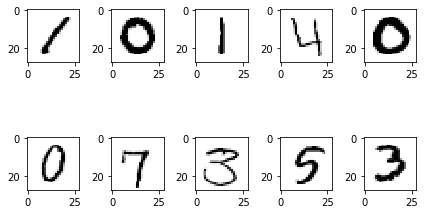

### 학습 시작 ###
Loss : 1.807641863822937
Loss : 0.2500529885292053
Loss : 0.19712196290493011
Loss : 0.1707918345928192
Loss : 0.15726202726364136
Loss : 0.14955709874629974
Loss : 0.14464639127254486
Loss : 0.14121003448963165
Loss : 0.13861213624477386
Loss : 0.13651256263256073
### 학습 종료 ###
### Training Data Set을 이용하여 성능평가!! ###
Accuracy : 0.9482312798500061


In [3]:
# MNIST 구현

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

# Raw Data Loading
df = pd.read_csv('./data/mnist/train.csv')
# display(df.head(), df.shape)

# 데이터의 명세를 잘 파악해야 해요!
# 각 픽셀의 값은 0 ~ 255 사이의 값을 가질 수 있어요!
# 이 값이 크면 클수록 어두운 색상이예요!

# 결측치와 이상치를 처리해보아요! 
# => 현재 데이터에는 이상치와 결측치가 없어요!

# 이미지 확인
img_data = df.drop('label', axis=1, inplace=False).values

fig = plt.figure()
fig_arr = []   # 10개의 subplot을 만들고 그 각각의 subplot을 list에 저장

for n in range(10):
    fig_arr.append(fig.add_subplot(2,5,n+1))
    fig_arr[n].imshow(img_data[n].reshape(28,28),
                     cmap='Greys',
                     interpolation='nearest')
plt.tight_layout()
plt.show()

# 데이터 분할
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('label', axis=1, inplace=False),
                df['label'],
                test_size=0.3,
                random_state=0)

# 정규화 작업!
scaler = MinMaxScaler()
scaler.fit(x_data_train)

x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

# Tensorflow 구현
sess = tf.Session()
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=10))
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=10))

# sklearn의 classification_report 사용을 위해 삭제하지 말자!
# del t_data_train
# del t_data_test

# placeholder
X = tf.placeholder(shape=[None,784], dtype=tf.float32)
T = tf.placeholder(shape=[None,10], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([784,10]), name='weight')
b = tf.Variable(tf.random.normal([10]), name='bias')

# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)  # softmax activation function

# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit,
                                                                 labels=T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)


# parameter
num_of_epoch = 1000
batch_size = 100

# 학습용 함수
def run_train(sess,train_x, train_t):
    print('### 학습 시작 ###')
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_t = train_t[i*batch_size:(i+1)*batch_size]           
            _, loss_val = sess.run([train,loss],
                                   feed_dict={X: batch_x,
                                              T: batch_t})
            
        if step % 100 == 0:
            print('Loss : {}'.format(loss_val))
    print('### 학습 종료 ###')
    
# Accuracy 측정(정확도)    
predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(T,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

# 학습부터 해요!
run_train(sess,x_data_train_norm, t_data_train_onehot)

# Training Data Set을 이용하여 성능평가!
print('### Training Data Set을 이용하여 성능평가!! ###')
result = sess.run(accuracy, feed_dict={X:x_data_train_norm,
                                       T:t_data_train_onehot})
print('Accuracy : {}'.format(result))
# Training Data Set을 이용하여 성능평가는 의미가 없어요!!

In [4]:
# 우리의 모델의 성능평가를 하기 위해
# K-Fold Cross Validation을 수행!

cv = 5          # Fold의 수
results = []    # 각 Fold당 학습과 성능평가가 진행되는데 
                # 이때 계산된 성능평가 값을 저장
kf = KFold(n_splits=cv, shuffle=True) 

for training_idx, validation_idx in kf.split(x_data_train_norm):
    training_x = x_data_train_norm[training_idx] # Fancy indexing
    training_t = t_data_train_onehot[training_idx]
    
    val_x = x_data_train_norm[validation_idx]
    val_t = t_data_train_onehot[validation_idx]
    
    # 학습부터 시켜야 해요!
    run_train(sess,training_x,training_t)
    results.append(sess.run(accuracy, feed_dict={X:val_x, T:val_t}))

print('측정한 각각의 결과값 : {}'.format(results))
print('최종 K-Fold 교차검증을 사용한 Accuracy : {}'.format(np.mean(results)))


### 학습 시작 ###
Loss : 2.118110418319702
Loss : 0.33573681116104126
Loss : 0.27072617411613464
Loss : 0.24413086473941803
Loss : 0.22932776808738708
Loss : 0.21859967708587646
Loss : 0.2098931074142456
Loss : 0.20263229310512543
Loss : 0.19656360149383545
Loss : 0.19149523973464966
### 학습 종료 ###
### 학습 시작 ###
Loss : 2.0347108840942383
Loss : 0.16694605350494385
Loss : 0.1175636500120163
Loss : 0.09996508806943893
Loss : 0.09230422973632812
Loss : 0.08862165361642838
Loss : 0.08670756965875626
Loss : 0.08560068160295486
Loss : 0.08486233651638031
Loss : 0.08430051058530807
### 학습 종료 ###
### 학습 시작 ###
Loss : 2.24507212638855
Loss : 0.22912541031837463
Loss : 0.1879740208387375
Loss : 0.16981324553489685
Loss : 0.15994060039520264
Loss : 0.15335720777511597
Loss : 0.14843784272670746
Loss : 0.14454159140586853
Loss : 0.14133279025554657
Loss : 0.13860653340816498
### 학습 종료 ###
### 학습 시작 ###
Loss : 3.013474941253662
Loss : 0.30607596039772034
Loss : 0.227263405919075
Loss : 0.187664419412612

In [5]:
# Testing
run_train(sess,x_data_train_norm,t_data_train_onehot)
final_accuracy = sess.run(accuracy, feed_dict={X:x_data_test_norm,
                                               T:t_data_test_onehot})
print('우리 Model의 최종 정확도는 : {}'.format(final_accuracy))



### 학습 시작 ###
Loss : 2.306431770324707
Loss : 0.24587564170360565
Loss : 0.18932422995567322
Loss : 0.17550379037857056
Loss : 0.16902042925357819
Loss : 0.1651279479265213
Loss : 0.1623324751853943
Loss : 0.1600288450717926
Loss : 0.1579582393169403
Loss : 0.15600690245628357
### 학습 종료 ###
우리 Model의 최종 정확도는 : 0.913095235824585


'              precision    recall  f1-score   support\n\n       num 0       0.95      0.95      0.95      1242\n       num 1       0.95      0.97      0.96      1429\n       num 2       0.91      0.89      0.90      1276\n       num 3       0.91      0.89      0.90      1298\n       num 4       0.92      0.91      0.92      1236\n       num 5       0.86      0.88      0.87      1119\n       num 6       0.93      0.95      0.94      1243\n       num 7       0.94      0.92      0.93      1334\n       num 8       0.87      0.87      0.87      1204\n       num 9       0.88      0.89      0.89      1219\n\n    accuracy                           0.91     12600\n   macro avg       0.91      0.91      0.91     12600\nweighted avg       0.91      0.91      0.91     12600\n'

In [6]:
# 만약 Precision, Recall, F1, Accuracy를 각각 구하고 싶으면?
# 첫번째 인자로 정답이 들어가야 해요(one hot encoding이 안된형태)
target_names=['num 0', 'num 1', 'num 2', 'num 3', 'num 4', 'num 5',
              'num 6', 'num 7', 'num 8', 'num 9']
print(
classification_report(t_data_test,
                     sess.run(predict, feed_dict={X:x_data_test_norm}),
                     target_names = target_names))

              precision    recall  f1-score   support

       num 0       0.95      0.95      0.95      1242
       num 1       0.95      0.97      0.96      1429
       num 2       0.91      0.89      0.90      1276
       num 3       0.91      0.89      0.90      1298
       num 4       0.92      0.91      0.92      1236
       num 5       0.86      0.88      0.87      1119
       num 6       0.93      0.95      0.94      1243
       num 7       0.94      0.92      0.93      1334
       num 8       0.87      0.87      0.87      1204
       num 9       0.88      0.89      0.89      1219

    accuracy                           0.91     12600
   macro avg       0.91      0.91      0.91     12600
weighted avg       0.91      0.91      0.91     12600



In [8]:
# sample code로 confusion matrix를 출력해보아요!
# 3개의 label(정답)이 있는 multinomial classification에 대해
# 예측값을 넣어서 confusion matrix를 출력해 보아요!

from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0,1]
y_pred = [0, 0, 2, 2, 0,2]

print(confusion_matrix(y_true,y_pred))

[[2 0 0]
 [0 0 1]
 [1 0 2]]


In [9]:
print(
confusion_matrix(t_data_test,
                     sess.run(predict, feed_dict={X:x_data_test_norm})))

[[1178    0   12    6    2    9   24    1    9    1]
 [   1 1385   12    5    1    4    5    0   13    3]
 [  13   18 1138   25   14    8   17   14   21    8]
 [   7    7   27 1151    2   47    4    8   29   16]
 [   4   13   10    2 1130    4   11    6   12   44]
 [   7    6    7   30    8  982   21    6   40   12]
 [   8    3   16    0   15   16 1178    0    7    0]
 [   2    6   17    7   16    7    1 1227    6   45]
 [   6   18   11   34    9   47   11    3 1045   20]
 [  11    3    3   11   29   13    0   44   14 1091]]


(198, 132, 3)
(198, 132)


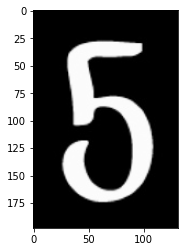

이미지의 크기 : 26136
이미지의 shape : (198, 132)


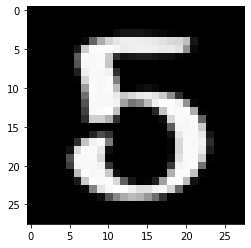

In [19]:
# 실제 이미지를 가지고 예측을 해 보아요!
# 이게 어려워요! 이미지 처리를 해야해요!

# 이미지를 하나 구해야 해요!
# 구한 color 이미지를 grey 이미지로 변환 => opencv를 이용

import numpy as np
import cv2  
from PIL import Image   # conda install Pillow
import matplotlib.pyplot as plt

my_img = cv2.imread('./data/mnist/digit/5.jpg', cv2.IMREAD_COLOR)
print(my_img.shape)   # (198, 132, 3)
im_grey = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)
print(im_grey.shape)
cv2.imwrite('./data/mnist/digit/5_grey.jpg', im_grey)

# 흑백이미지 파일을 얻었어요!
img = Image.open('./data/mnist/digit/5_grey.jpg')
plt.imshow(img, cmap='Greys')
plt.show()

# 사이즈가 안 맞아요!
pixel = np.array(img)
print('이미지의 크기 : {}'.format(pixel.size))
print('이미지의 shape : {}'.format(pixel.shape))

resize_img = img.resize((28,28))
plt.imshow(resize_img, cmap='Greys')
plt.show()